In [123]:
import os
import scipy
import torch
import numpy as np
import pandas as pd
from model.reconstruction import EncoderDecoder

In [124]:
def sliding_window(signal, window, stride):
    length = signal.shape[-1]
    start = []
    i = 0
    x = []
    while i < length-window:
        x.append(signal[:, i:i+window])
        start.append(i)
        i += stride
    if start[-1] < length - window:
        x.append(signal[:, length-1024:length])
        start.append(length-1024)
    return x, start

In [125]:

def min_max_scaler(signal):
    min_max = pd.read_csv("./RawData/Acceleration/min_max.csv").values
    new_signal = np.copy(signal)
    for i in range(signal.shape[0]):
        if len(np.unique(signal[i, :] )) != 1:
            new_signal[i, :] = (signal[i, :] - min_max[i][0])/(min_max[i][1] - min_max[i][0])
    return new_signal

In [126]:
def denormalize(signal):
    min_max = pd.read_csv("./RawData/Acceleration/min_max.csv").values
    new_signal = np.copy(signal)
    for i in range(signal.shape[0]):
        new_signal[i, :] = signal[i, :] * (min_max[i][1] - min_max[i][0]) + min_max[i][0]
    return new_signal

## Scenarion A

In [127]:
name, _, _ = scipy.io.whosmat("./RawData/Acceleration/data_noised_testset1.mat")[0]
data = scipy.io.loadmat("./RawData/Acceleration/data_noised_testset1.mat")[name]
normalized_data = min_max_scaler(data)

In [128]:
state_dict = torch.load("./Logs/Reconstruction/Acceleration-From_Scratch/LAST/version_0/checkpoints/epoch=00457-val_loss=0.0015.ckpt")["state_dict"]
model = EncoderDecoder(source="Accleration").to("cuda").eval()
model.load_state_dict(state_dict=state_dict)

<All keys matched successfully>

In [129]:
data_list, start = sliding_window(normalized_data, window=1024, stride=1024)

In [130]:
final_prediction = np.zeros((data.shape[0], data.shape[1]))
with torch.no_grad():
    for signal, s in zip(data_list, start):
        input = torch.tensor(signal, dtype=torch.float32).to("cuda").unsqueeze(0)
        prediction = model(input).squeeze().cpu().numpy()
        final_prediction[:, s:s+1024] = denormalize(prediction)


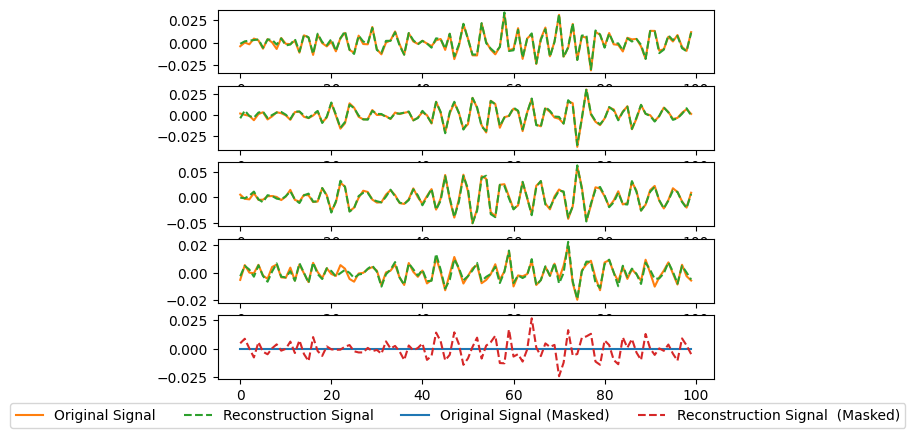

In [131]:
import matplotlib.pyplot as plt
fig, axes = plt.subplots(5, 1)
for i in range(5):
    if len(np.unique(data[i, :])) != 1:
        line1 = axes[i].plot(range(len(data[i, :100])), data[i, :100], color="tab:orange",  label="Original Signal")
        line2 = axes[i].plot(range(len(final_prediction[i, :100])), final_prediction[i, :100], color="tab:green", linestyle="--",  label="Reconstruction Signal")          
    else:
        line3 = axes[i].plot(range(len(data[i, :100])), data[i, :100], color="tab:blue",  label="Original Signal (Masked)")
        line4 = axes[i].plot(range(len(final_prediction[i, :100])), final_prediction[i, :100], color="tab:red", linestyle="--",  label="Reconstruction Signal  (Masked)") 
fig.legend(handles =[line1[0], line2[0], line3[0], line4[0]], loc ='lower center', ncol=4)

In [132]:
np.savetxt("./prediction/reconstruction/project3_a_task.txt", final_prediction[4, :], fmt='%f', delimiter=",")

## Scenario B

In [133]:
name, _, _ = scipy.io.whosmat("./RawData/Acceleration/data_noised_testset2.mat")[0]
data = scipy.io.loadmat("./RawData/Acceleration/data_noised_testset2.mat")[name]
normalized_data = min_max_scaler(data)

In [134]:
state_dict = torch.load("./Logs/Reconstruction/Acceleration-From_Scratch/LAST/version_0/checkpoints/epoch=00457-val_loss=0.0015.ckpt")["state_dict"]
model = EncoderDecoder(source="Accleration").to("cuda").eval()
model.load_state_dict(state_dict=state_dict)

<All keys matched successfully>

In [135]:
data_list, start = sliding_window(normalized_data, window=1024, stride=1024)

In [136]:
final_prediction = np.zeros((data.shape[0], data.shape[1]))
with torch.no_grad():
    for signal, s in zip(data_list, start):
        input = torch.tensor(signal, dtype=torch.float32).to("cuda").unsqueeze(0)
        prediction = model(input).squeeze().cpu().numpy()
        final_prediction[:, s:s+1024] = denormalize(prediction)


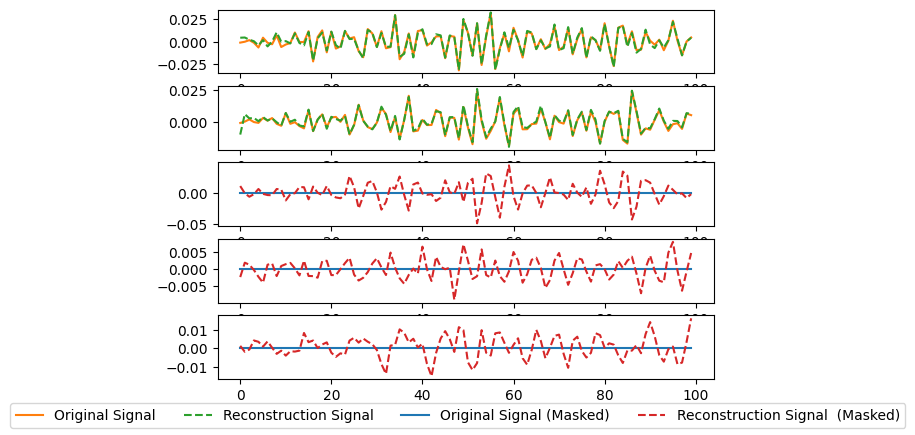

In [137]:
import matplotlib.pyplot as plt
fig, axes = plt.subplots(5, 1)
for i in range(5):
    if len(np.unique(data[i, :])) != 1:
        line1 = axes[i].plot(range(len(data[i, :100])), data[i, :100], color="tab:orange",  label="Original Signal")
        line2 = axes[i].plot(range(len(final_prediction[i, :100])), final_prediction[i, :100], color="tab:green", linestyle="--",  label="Reconstruction Signal")          
    else:
        line3 = axes[i].plot(range(len(data[i, :100])), data[i, :100], color="tab:blue",  label="Original Signal (Masked)")
        line4 = axes[i].plot(range(len(final_prediction[i, :100])), final_prediction[i, :100], color="tab:red", linestyle="--",  label="Reconstruction Signal  (Masked)") 
fig.legend(handles =[line1[0], line2[0], line3[0], line4[0]], loc ='lower center', ncol=4)

In [138]:
np.savetxt("./prediction/reconstruction/project3_b_task.txt", final_prediction[2:5, :], fmt='%f', delimiter=",")